# Cryosphere model Comparison tool (CmCt) GRACE Mascon Gravimetry Tool

## About this Tool

The CmCt GRACE Mascon Gravimetry Tool compares the user's uploaded ice sheet model(s) to gravimetry data from NASA's GRACE mission. The model is expected as a rectangular grid in ISMIP6 polar-stereographic coordinates (see the Input Data Requirements section). The observation data consists of a list of mascons, equal-area segments of the globe, each of which have time series data for mass of water contained in the mascon (read more [here](https://grace.jpl.nasa.gov/data/get-data/jpl_global_mascons/)). The residual value for each mascon is the average of the value for all model points spatially contained within the mascon minus the observation value for that mascon. This tool also only compares change in ice mass over time, where the user can specify start and end dates.

### Mascon dataset
For comparison to the user's model, the tool currently uses the `gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd` GRACE mascon product from Apr 2003 to Dec 2023 that can be requested [here](https://earth.gsfc.nasa.gov/geo/data/grace-mascons). This dataset is available upon request. In addition, for plotting coastlines, this tool uses data that can be downloaded from [here](https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/)

### Multiple Comparisons
This tool uses parallel processing to allow the user to efficiently compare multiple model files with multiple observation files. A comparison can occur between the observation data and any model file listed in the `model_fns` input for any start and end date for which both the observation and the model have data. The user may request any amount of comparisons be done. See the "Desired Comparisons" subsection of the "Input Data Requirements" section for more information.

## Input data requirements

### Input netCDF File(s) Requirements
The user may include multiple netCDF4 model files, but they must contain these four variables: x, y, time, and lithk

### Coordinate System
Coordinates are defined on a rectangular X-Y grid in the ISMIP6 standard projected polar-stereographic space. The ISMIP6 standard projection is defined [here](https://theghub.org/groups/ismip6/wiki/MainPage). This means that in the model netCDF4 file, there must be variables x and y such that x has dimensions (x,) and length A and y has dimensions (y,) and length B. In addition, the lithk variable must have dimensions (time, y, x,) and shape (_, B, A). If multiple netCDF4 files are entered as inputs, their x and y variables are assumed to be the same. 

### Time variable
The model file must include a time variable whose entries are cftime objects. This variable must be in increasing order and have at least two entries. If multiple netCDF4 files are entered as inputs, their time variables may be different (i.e. one model file may include data from 1996 to 2006, another may include data from 2000 to 2010).

#### `Lithk` variable
The CmCt Grace Mascon tool expects the uploaded model to contain thickness data (the `lithk` variable) for the comparison (should be in units of meters). lithk must have dimensions (time, y, x). 

### Desired Comparisons
The filenames of all model files the user wishes to include should be listed in the variable `model_fns` as a list of strings. The input `desired_comparisons` is a list of 3-tuples of the form `(idx_mod, start_date, end_date)`. `idx_mod` is an index of `model_fns` to indicate the model dataset. `start_date` and `end_date` should be strings of the form "YYYY-MM-DD" representing the start and end dates of the comparison. Note that `start_date` and `end_date` cannot occur before the start of observation data collection (Apr 2003) or after the end of observation data collection (Dec 2023).

## Outputs and Plotting

The CmCt offers multiple options for output saving and plotting. 

### Saving
If the input `save_nc` is False, the CmCt will not save any netCDF files. Otherwise, in the case that only one comparison is desired, the CmCt will create a netCDF file (with the filename being the first entry of the `output_fns` list) which has the dimension `mascon` and the variable `cmwe_res`. cmwe_res will store the residual of the comparison for each mascon.

In the case that multiple comparisons are desired (and `save_nc` is True), the user has two options controlled by the input variable `single_file_nc`. If `single_file_nc` is False, then each residual will be saved in a netCDF file of the form described above. The comparison described by desired_comparisons\[i] will be saved with the filename output_fn\[i]. 

If `single_file_nc` is True, then all residuals will be stacked and saved in a single netCDF file to the filename output_fns\[0]. This file will have the following variables: model_id, start_date, end_date, all_cmwe_res. There is also a "comparison" dimension, which has the same length as desired_comparisons, and a "mascon" dimension. all_cmwe_res has the dimensions (comparison, y, x), where all_cmwe_res\[i,:,:] is the residual for desired_comparison\[i]. model_id, start_date, and end_date each have form (comparisons,) and store model id (given by the input `model_ids`), start date, and end date for each comparison respectively. If the `model_fn_ids` input is None, then the model_id for each model will be the filename given in
`model_fn` (this is not recommended).

### Plotting
The `plot` variable is an array of booleans with the same length as `desired_comparisons`, and if `plot`\[i] is True, the observation data, model data, and residual for `desired_comparisons`\[i] will be plotted. The `save_plot` variable is an array of booleans with the same length as `desired_comparisons`, and if `plot`\[i] and `save_plot`\[i] are True, the plot for `desired_comparisons`\[i] will be saved to `plot_fn`\[i].

## Using this tool

This tool runs in Jupyter Appmode. The user interface buttons enable upload, plotting, and download.

1. Download the example output, if desired, using the Download Example button.
1. Upload model data for comparison using the Upload File button.
1. Plot GRACE Mascon and Ice Sheet Model Comparison using the Plot Data button.
1. Download the results using the Download Plot button.

# Import Modules

In [1]:
# set geospatial python3 kernel to provide needed packages
import os,sys
import glob as glob
import numpy as np
import h5py
import xarray as xr
import time
import concurrent.futures
from datetime import datetime

import cartopy
import cartopy.crs as ccrs
import cartopy.io.shapereader as shpreader

import matplotlib.pyplot as plt
from matplotlib import rc
rc('mathtext', default='regular')

sys.path.insert(0, os.path.abspath('..'))

import ipywidgets as widgets
from IPython.display import display,clear_output,HTML
import PIL.Image # Python Image Library

import mascons
import grav_utils
%cd "/home/jovyan/CmCt/notebooks"
import notebook_utils as utils

# note: suppress numpy.dtype size changed warnings
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings('ignore')
%cd "/home/jovyan/CmCt/notebooks/Gravimetry"

/home/jovyan/CmCt/notebooks
/home/jovyan/CmCt/notebooks/Gravimetry


# Enter Inputs

In [2]:
##### Choose desired ice sheet #####
loc = "GIS"  # Possible choices include "GIS" or "AIS"

model_fns = ["/home/jovyan/CmCt/notebooks/Gravimetry/model_files/lithk_GIS_BGC_BISICLES_historical.nc", 
             "/home/jovyan/CmCt/notebooks/Gravimetry/model_files/lithk_GIS_GSFC_ISSM_historical.nc"]

# A list of 3-tuples of the form (index in model_fns, start_date, end_date)
# The latter two must be of the form 'YYYY-MM-DD'
desired_comparisons = [(0, '2012-01-01', '2013-01-01'),
                       (1, '2012-01-01', '2013-01-01')]

# Initialize optional variables to None
single_file_nc, output_fns, model_fn_ids, save_plot, plot_fn = None, None, None, None, None

##### Saving #####
save_nc = True
if save_nc:
    single_file_nc = True
    output_fns = ["output_files/Mascon_comp.nc"]
    if single_file_nc:
        model_fn_ids = ["lithk_GIS_BGC_BISICLES_historical", "lithk_GIS_GSFC_ISSM_historical"]

##### Plotting #####
# If true, plots the GRACE Mascon data, model prediction data, and residual in units of centimeters of water equivalent
plot = [True, True]
if np.sum(plot):      
    save_plot = [False, False]
    if np.sum(save_plot): 
        plot_fn = ["comp1.png", "comp2.png"]

global error
error, error_string = utils.check_input_validity(save_nc, output_fns, single_file_nc, len(desired_comparisons), 
                                      model_fn_ids, len(model_fns), plot, save_plot, plot_fn, 
                                     loc = loc)

## Set Polar Sterographic Projection definition

In [3]:
# Method : Set model projection from standard definition
if loc == "GIS":
    polar_stereographic = ccrs.Stereographic(
        central_latitude= 90.0,
        central_longitude= -45.0,
        false_easting= 0.0,
        false_northing= 0.0,
        true_scale_latitude= 70.0,
        globe=ccrs.Globe('WGS84')
    )
elif loc == "AIS":
    polar_stereographic = ccrs.Stereographic(
        central_latitude= -90.0,
        central_longitude= 0.0,
        false_easting= 0.0,
        false_northing= 0.0,
        true_scale_latitude= -71.0,
        globe=ccrs.Globe('WGS84')
    )

# Select Parameters and Construct Output File

In [4]:
from CMCT_gaivimetry_select_data_parameters import *


parameters = CMCT_gaivimetry_select_data_parameters()
print(parameters)

{'loginname_widget': 'rbasnet'}


## Load GRACE and Model Data:

In [5]:
def loadGsfcMascons(desired_comparisons):
    t = time.time()
    #Load Mascons data
    inpath_1 =os.path.expanduser('/home/jovyan/CmCt/notebooks/Gravimetry/mascon_files/')

    # Load GSFC mascons
    h5_filename = inpath_1 + 'gsfc.glb_.200204_202312_rl06v2.0_obp-ice6gd.h5'

    try:
        gsfc = mascons.load_gsfc_solution(h5_filename, lon_wrap='pm180')
    except:
        print('Error: Failed to load GSFC mascons.')
        return None
        
    return gsfc

In [6]:
# Load user's uploaded model data
def loadGisModel(model_fns, desired_comparisons):
    t = time.time()

    comp_info = grav_utils.interpret_comparisons_mod(desired_comparisons)

    all_gis_ds = []
    for mod_idx in comp_info:
        # Load GIS model into an Xarray
        try:
            gis_ds = xr.open_dataset(model_fns[mod_idx], autoclose=True, engine='netcdf4')
        except:
            print('Error: Failed to open model data; FileNotFound error or unexpected format. Terminating calculation.')
            return None

        
        # check for the lithk variable
        try:
            lithk = gis_ds['lithk']
        except:
            print('Error: lithk variable expected but not found in model. Terminating calculation.')
            return None
        all_gis_ds.append(gis_ds) 

    return all_gis_ds

# GRACE Mascon Mean Computation

In [7]:
# Compute mascon means
def computeMasconMeans(gsfc, desired_comparisons):
    t = time.time()
    
    global lat_centers
    global lon_centers
    global max_lons
    global min_lons
    global min_lats
    global max_lats
    global min_mscns
    global max_mscns
    global diverging_max
    global diverging_min
    global I_

    # Select only desired mascons
    if loc == "GIS":
        I_ = gsfc.locations == 1
    elif loc == "AIS":
        I_ = (gsfc.locations == 3) | (gsfc.locations == 4)

    # Interpret comparisons: This avoids computing the same cmwe for the same time range multiple times
    comp_info, comp_2_obs_idx = grav_utils.interpret_comparisons_obs(desired_comparisons)
    if not utils.all_comparisons_in_time_bounds(comp_info.keys(), gsfc.times_start[0], gsfc.times_end[-1], utils.dt64_to_dt): return None
    
    all_cmwe_obs = mascons.calc_many_mascon_delta_cmwes(gsfc, comp_info.keys(), I_)
    # Note: comp_2_obs_idx only corresponds to all_cmwe_obs because comp_info is not modified before all_cmwe_obs is created
    if all_cmwe_obs is None:   # Error already printed in line above
        return None
        
    lat_centers = gsfc.lat_centers[I_]
    lon_centers = gsfc.lon_centers[I_]
    min_lons = gsfc.min_lons[I_]
    max_lons = gsfc.max_lons[I_]
    min_lats = gsfc.min_lats[I_]
    max_lats = gsfc.max_lats[I_]

    min_mscns = np.min(np.array([np.min(cmwe_delta) for cmwe_delta in all_cmwe_obs]))
    max_mscns = np.max(np.array([np.max(cmwe_delta) for cmwe_delta in all_cmwe_obs]))

    diverging_max = np.max([np.abs(min_mscns), np.abs(max_mscns)])
    diverging_min = -diverging_max

    return all_cmwe_obs, comp_2_obs_idx

## Ice Sheet Model Mascon Mean Computation 

In [8]:
def transformToGeodetic(gsfc, all_gis_ds, desired_comparisons):
    t = time.time()
    
    # Put model into mascon space:

    # To compare with GRACE mascons, we need to compute lat/lon coordinates 
    # for the grid locations and average them into the GSFC mascon boundaries.

    # First, we must transform from the original polar stereographic projection 
    # into a geodetic lat/lon coordinate system. We plot the result of 
    # this transformation to verify that the transformation was successful.

    # Then, we spatially average the data into mascon space and once more plot our result.

    # Initialize outputs
    all_cmwe_mod = []
    comp_2_mod_idx = np.empty((len(desired_comparisons),), dtype = "int")
    
    comp_info = grav_utils.interpret_comparisons_mod(desired_comparisons)

    # Transform projection to lat/lon
    geodetic = ccrs.Geodetic(globe=ccrs.Globe('WGS84'))
    yv, xv = np.meshgrid(all_gis_ds[0].y.data, all_gis_ds[0].x.data)   # x and y information in polar stereographic
    ll = geodetic.transform_points(src_crs=polar_stereographic, x=xv.flatten(), y=yv.flatten())
    lons = ll[:,0]
    lats = ll[:,1]

    for i, mod_idx in enumerate(comp_info):
    
        # fetch the lithk variable from the model data structure
        lithk = (all_gis_ds[i])['lithk']    # type: xarray.core.dataarray.DataArray

        for time_id in comp_info[mod_idx]:
            start_date, end_date = time_id
    
            lithk_delta = subtractLithkFromStartToEndDate(lithk, start_date, end_date)
            if lithk_delta is None:
                return None, None
        
            # Mascon-average lithk from GIS
            lithk_delta[np.isnan(lithk_delta)] = 0

            # Ice thickness (m) to cm water equivalent:
            rho_ice = 934 # kg/m^3
            rho_water = 1000 # kg/m^3
            lithk_delta = lithk_delta * rho_ice / rho_water * 100

            # Add to output variables
            all_cmwe_mod.append(lithk_delta)
            i = len(all_cmwe_mod) - 1
            for j in (comp_info[mod_idx])[time_id]:
                comp_2_mod_idx[j] = i


    # Interpolate to mascon space
    all_cmwe_mod_interped = mascons.points_to_mascons(gsfc, I_, lats, lons, all_cmwe_mod)
    
    return all_cmwe_mod_interped, comp_2_mod_idx

In [9]:
def subtractLithkFromStartToEndDate(lithk, start_date, end_date):
    if not utils.time_within_bounds(datetime.strptime(start_date, "%Y-%m-%d"), lithk.time.data,
                                    "start_date", "model_data", utils.cftime_to_dt):
        return None
    if not utils.time_within_bounds(datetime.strptime(end_date, "%Y-%m-%d"), lithk.time.data,
                                    "end_date", "model_data", utils.cftime_to_dt):
        return None

    # Interpolate lithk value for start and end dates
    lithk_start = lithk.interp(time=start_date).data.transpose().flatten()
    lithk_end = lithk.interp(time=end_date).data.transpose().flatten()

    # Compute estimated change in ice thickness between start and end dates
    lithk_delta = lithk_end - lithk_start
    return lithk_delta

## Compute Residuals

In [10]:
def compute_residuals(all_cmwe_obs, all_cmwe_mod, comp_2_obs_idx, comp_2_mod_idx):
    """
    For each comparison in desired_comparisons, computes the residual and outputs all residuals
    as a list such that all_dh_res[i] corresponds to desired_comparison[i]
    """
    all_cmwe_res = []
    for i in range(len(comp_2_obs_idx)):
        obs_i = comp_2_obs_idx[i]
        mod_i = comp_2_mod_idx[i]
        all_cmwe_res.append(all_cmwe_mod[mod_i] - all_cmwe_obs[obs_i])  # residual = model - observation
    return all_cmwe_res

## Plot

In [11]:
def plotFigure(cmwe_delta, mscns_trim, cmwe_diff, gsfc, I_, start_date, end_date, save, fn):
    plt.figure(figsize=(24,14)) #, dpi=300)

    if loc == "GIS":
        extent = [-65, -20, 57, 84]
    elif loc == "AIS":
        extent = [-135, 45, -52, -52]
    else:
        print(f"Error: Input loc is equal to '{loc}', not 'AIS' or 'GIS")
        return None
    
    # Observed
    ax1 = plt.subplot(131, projection=polar_stereographic)
    ax1.set_extent(extent) # Map bounds, [west, east, south, north]
    sc = ax1.scatter(lon_centers, lat_centers, 1, c=cmwe_delta, zorder=0, transform=ccrs.PlateCarree(),
                     cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)
    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(cmwe_delta))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax1.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())
    
    c = plt.colorbar(sc, orientation='horizontal', ax=ax1, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax1.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')
    # download coastline here: https://www.naturalearthdata.com/downloads/10m-physical-vectors/10m-coastline/

    # Add coastlines on top
    ax1.coastlines(resolution='10m', zorder=10, linewidth=0.5)    
    # Add gridlines
    ax1.gridlines(zorder=5, linestyle=':', linewidth=0.5)

    ax1.set_title('Observed mass change\n({0} to {1})'.format(start_date, end_date), size=14)

    sc.remove()


    # Modeled
    ax2 = plt.subplot(132, projection=polar_stereographic)
    ax2.set_extent(extent) # Map bounds, [west, east, south, north]

    sc = ax2.scatter(gsfc.lon_centers[I_], gsfc.lat_centers[I_], 1, c=mscns_trim, zorder=0,
                     transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)

    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(mscns_trim))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax2.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax2, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax2.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # Add coastlines on top
    ax2.coastlines(resolution='10m', zorder=10, linewidth=0.5)    
    # Add gridlines
    ax2.gridlines(zorder=5, linestyle=':', linewidth=0.5)

    # add model filename to subplot's title
    ax2.set_title('Modeled mass change\n({0} to {1})'.format(start_date, end_date), size=14)

    sc.remove()
    
    # add some explanatory information
    plt.suptitle('Grace Mascon Comparison Plots', fontsize=25)
    plt.subplots_adjust(top=0.83)


    # Obeserved-Modeled
    ax3 = plt.subplot(133, projection=polar_stereographic)
    ax3.set_extent(extent) # Map bounds, [west, east, south, north]

    sc = ax3.scatter(lon_centers, lat_centers, 1, c=cmwe_diff, zorder=0, transform=ccrs.PlateCarree(),
                     cmap=plt.cm.RdBu, vmin=diverging_min, vmax=diverging_max)    
    
    normal = plt.Normalize(diverging_min, diverging_max)
    cmap = plt.cm.RdBu(normal(cmwe_diff))

    N_ints = 10
    for i in range(len(mscns_trim)):
        x = np.append(np.linspace(min_lons[i], max_lons[i], N_ints), np.linspace(max_lons[i], min_lons[i], N_ints))
        y = np.append(min_lats[i]*np.ones(N_ints), max_lats[i]*np.ones(N_ints))
        ax3.fill(x, y, facecolor=cmap[i][:], edgecolor='none', zorder=5, transform=ccrs.PlateCarree())

    c = plt.colorbar(sc, orientation='horizontal', ax=ax3, pad=0.04) #, fraction=0.046)
    c.set_label('cm water eq.', size=14)
    c.ax.tick_params(labelsize=12)

    ax3.add_geometries(list(shpreader.Reader(os.path.expanduser('/home/jovyan/CmCt/datasets/ne_10m_coastline/ne_10m_coastline.shp')).geometries()), \
       ccrs.PlateCarree(), edgecolor='black', facecolor='none')

    # Add coastlines on top
    ax3.coastlines(resolution='10m', zorder=10, linewidth=0.5)    
    # Add gridlines
    ax3.gridlines(zorder=5, linestyle=':', linewidth=0.5)

    ax3.set_title('Residual mass change\n({0} to {1})'.format( start_date, end_date), size=14)

    sc.remove()
    
    # add some explanatory information
    plt.suptitle('Grace Mascon Comparison Plots', fontsize=25)
    plt.subplots_adjust(top=1.93)#0.83

    if save:
        t7 = time.time()
        plt.savefig(fn)
        print("Saving figure: " + str(time.time() - t7))

    plt.show()

# Compare GRACE Mascon and Ice Sheet Model

In [12]:
# do the computation
def runProcessing():    
    if error:
        print(error_string)
        return None
    update_progress(0, "Starting...              ", 0.0)
    
    # load mascons 
    t = time.time()
    gsfc = loadGsfcMascons(desired_comparisons)
    if gsfc is not None:
        update_progress(0.10, "Loaded GRACE data        ", time.time() - t)
    else: 
        return None
    
    # load user's input model
    t = time.time()
    all_gis_ds = loadGisModel(model_fns, desired_comparisons)
    if all_gis_ds is None:
        return None
    update_progress(0.20, "Loaded Model Data        ", time.time() - t)
    
    # compute the mascon means
    t = time.time()
    all_cmwe_obs, comp_2_obs_idx = computeMasconMeans(gsfc, desired_comparisons)
    if all_cmwe_obs is None:
        return None
    update_progress(0.30, "Computed GRACE Delta cmwe", time.time() - t)

    
    # Put model into mascon space
    t = time.time()
    all_cmwe_mod_interped, comp_2_mod_idx = transformToGeodetic(gsfc, all_gis_ds, desired_comparisons)
    if all_cmwe_mod_interped is None:
        return None
    update_progress(0.60, "Computed Model Delta cmwe", time.time() - t) 
    

    # calculate and write results as netcdf file
    t = time.time()
    all_cmwe_res = compute_residuals(all_cmwe_obs, all_cmwe_mod_interped, comp_2_obs_idx, comp_2_mod_idx)
    if all_cmwe_res is None:
        return None
    update_progress(0.80, "Computed Residual        ", time.time() - t)

    # Save results to NetCDF
    if save_nc: 
        t = time.time()
        grav_utils.write_to_netcdf(all_cmwe_res, single_file_nc, output_fns, desired_comparisons, model_fn_ids, model_fns)
        update_progress(0.90, "Saved to netCDF          ", time.time() - t)
    
    # Plot results
    if np.sum(plot):
        t = time.time()
        print("Plotting.....")
        for i in range(len(desired_comparisons)):
            if plot[i]: plotFigure(all_cmwe_obs[comp_2_obs_idx[i]], all_cmwe_mod_interped[comp_2_mod_idx[i]], all_cmwe_res[i], gsfc, I_, 
                       desired_comparisons[i][1], desired_comparisons[i][2], save_plot[i], plot_fn[i] if save_plot[i] else None)
        update_progress(0.90, "Plotted                  ", time.time() - t)
        
    # todo: put in some checks
    print("Success")
    return 'Success'

In [13]:
# update processing progress bar
def update_progress(progress, title, time_elapsed_print):
    bar_length = 20
    block = int(20.0*progress)
    text = title+" [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100) + f" ({time_elapsed_print} seconds)"
    print(text)    

Starting...               [--------------------] 0.0% (0.0 seconds)
Loaded GRACE data         [##------------------] 10.0% (0.26853251457214355 seconds)
Loaded Model Data         [####----------------] 20.0% (0.5060067176818848 seconds)
Computed GRACE Delta cmwe [######--------------] 30.0% (0.0022110939025878906 seconds)
Computed Model Delta cmwe [############--------] 60.0% (0.7878575325012207 seconds)
Computed Residual         [################----] 80.0% (1.5974044799804688e-05 seconds)
Saved to netCDF           [##################--] 90.0% (0.01858806610107422 seconds)
Plotting.....


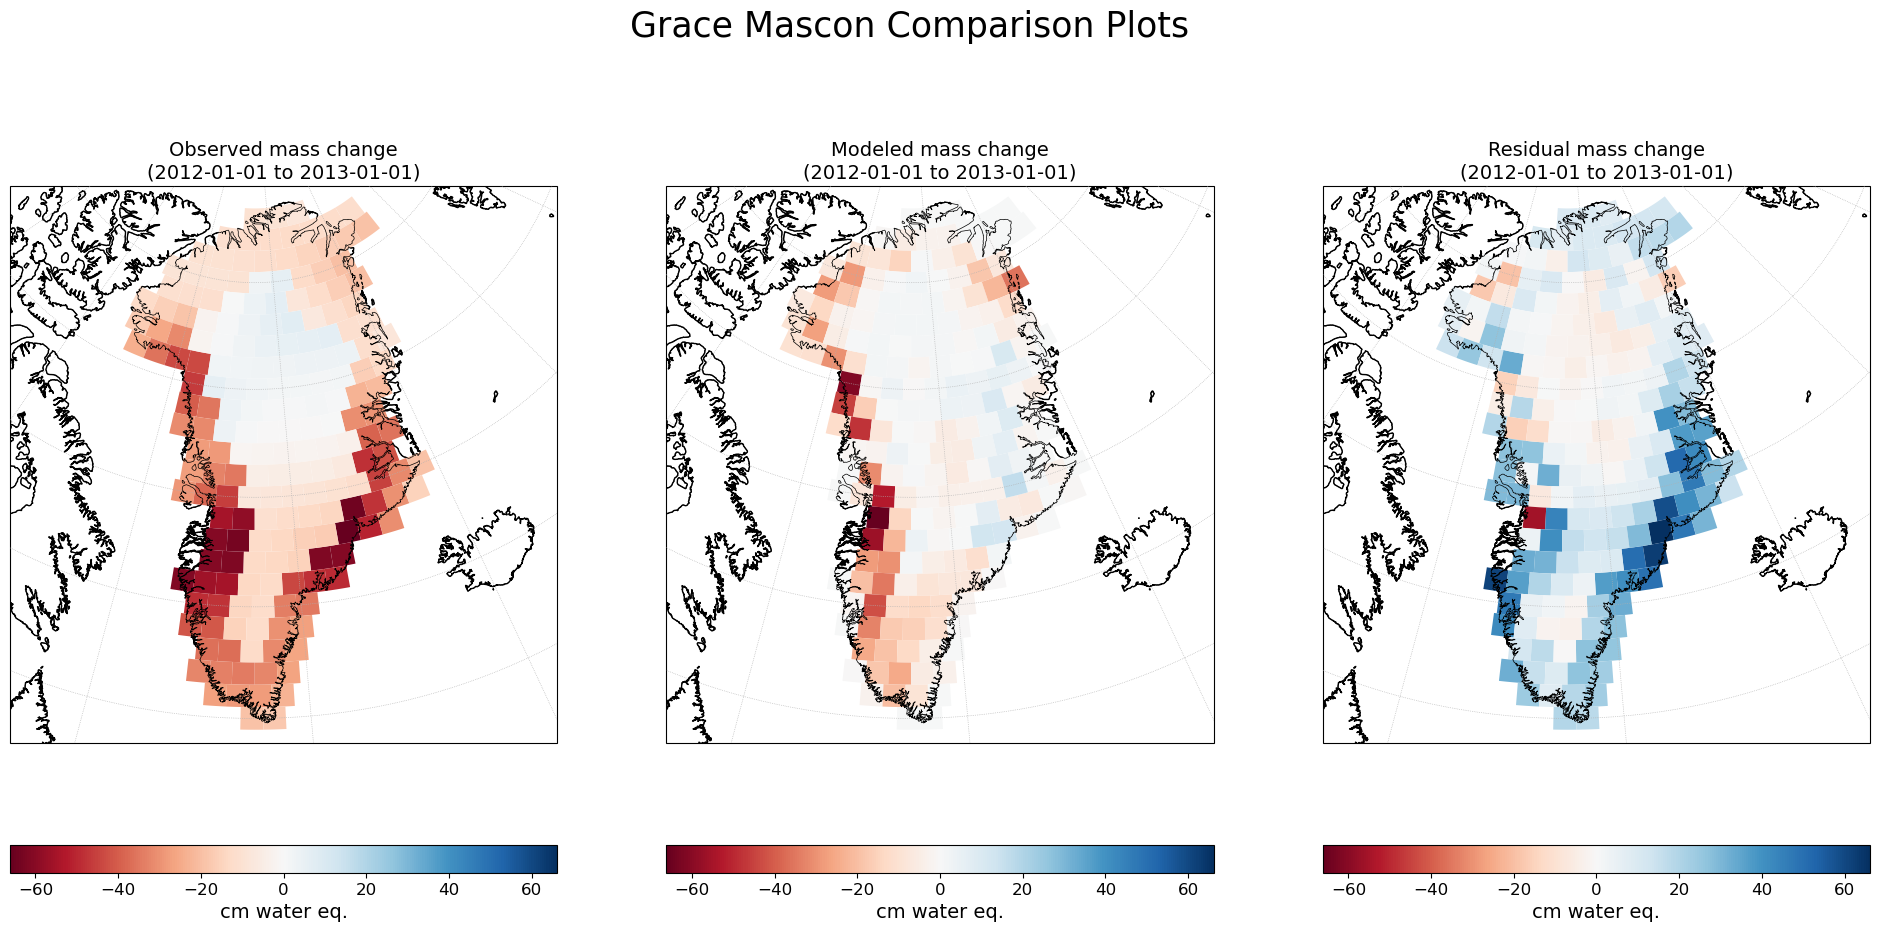

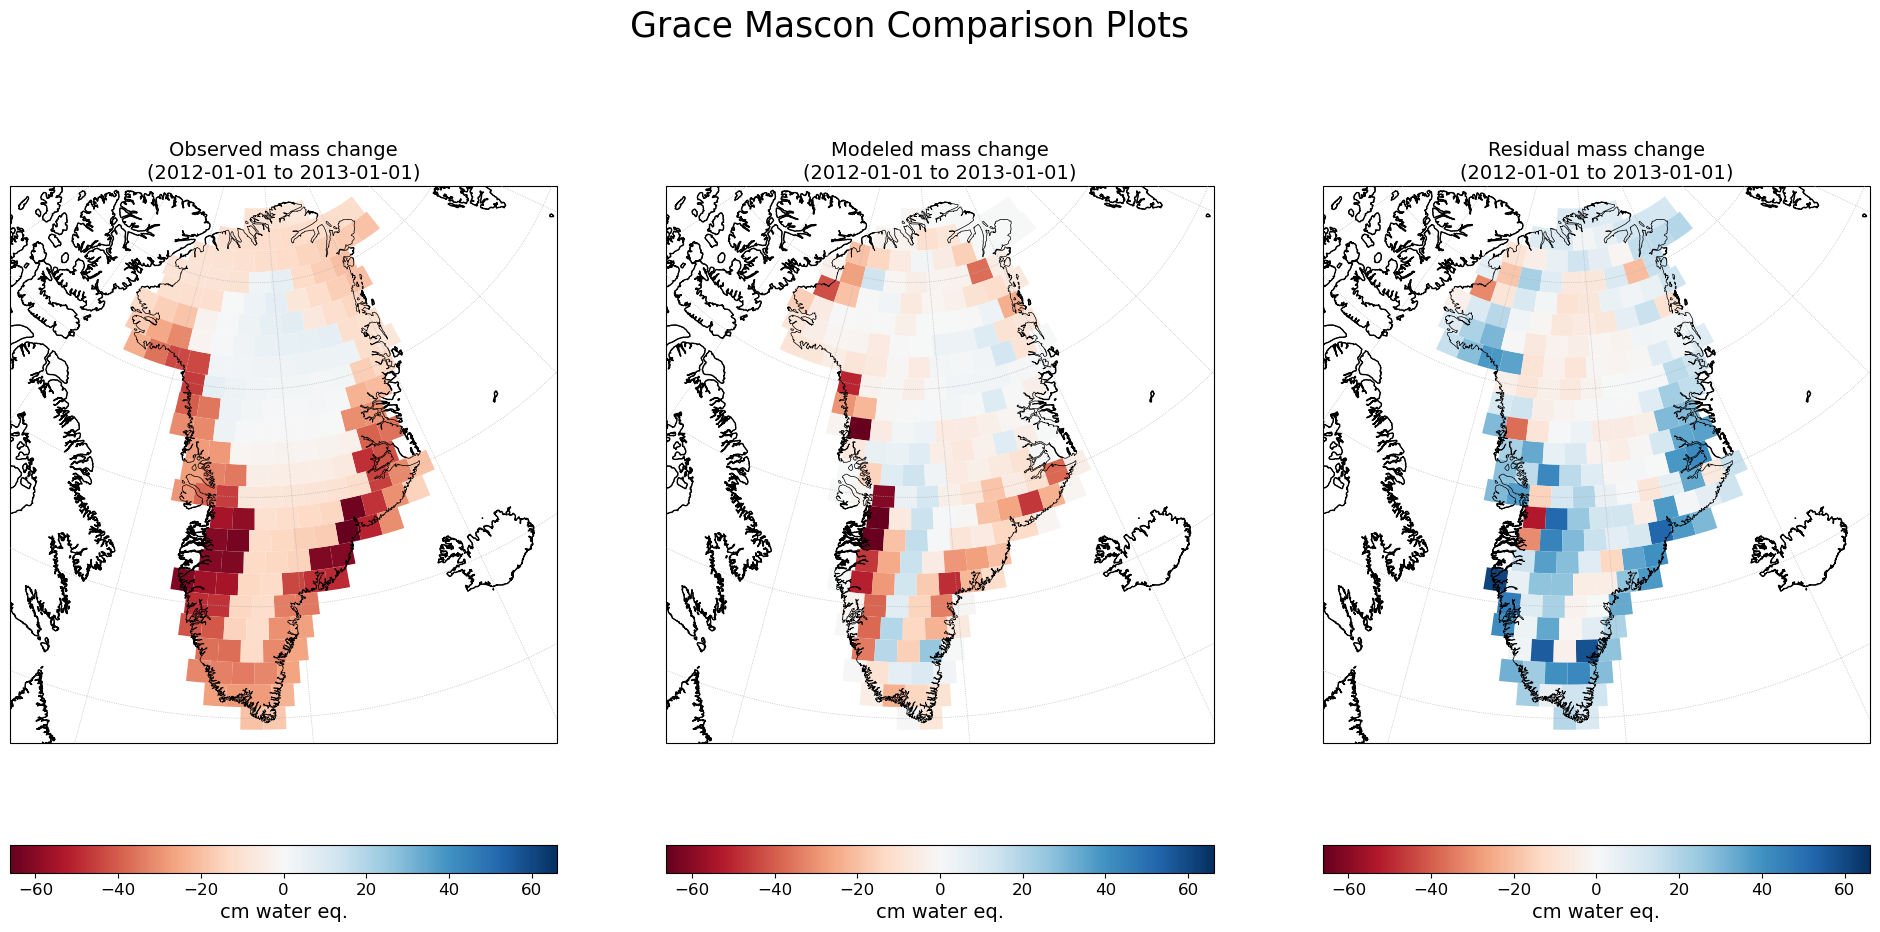

Plotted                   [##################--] 90.0% (54.713016748428345 seconds)
Success
Total time: 56.3106689453125 seconds


In [14]:
# Process
t_tot = time.time()
runProcessing()
print("Total time: " + str(time.time() - t_tot) + " seconds")